In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Загрузка датасета

In [2]:
df = pd.read_excel("/content/gdrive/MyDrive/data/vickers_hardness_dataset.xlsx")
df.head()

,Type_of_samples,P,D1,D2,HV
0,0,500,61.606,63.455,226.406
1,0,500,62.380,61.992,249.658
2,0,500,59.052,62.373,244.361
3,0,500,60.825,62.618,243.444
4,0,500,60.368,62.374,231.127


In [3]:
df.describe()

,Type_of_samples,P,D1,D2,HV
count,750.000000,750.000000,750.000000,750.000000,750.000000
mean,1.000000,320.000000,46.014587,45.994812,274.718868
std,0.817041,160.106773,14.088705,14.117520,63.642977
min,0.000000,100.000000,15.658000,17.777000,131.551000
25%,0.000000,200.000000,34.489000,34.883250,229.161250
50%,1.000000,300.000000,48.276500,48.346000,265.860500
75%,2.000000,500.000000,57.872750,57.512500,316.910250
max,2.000000,500.000000,75.205000,76.127000,581.744000


In [4]:
columns = ['Type_of_samples', 'P', 'D1', 'D2']

In [5]:
df.isnull().sum()

Type_of_samples    0
P                  0
D1                 0
D2                 0
HV                 0
dtype: int64

In [6]:
df['HV'].value_counts()

271.584    5
278.914    4
380.861    4
228.887    4
353.125    3
          ..
202.600    1
241.111    1
208.088    1
254.022    1
250.292    1
Name: HV, Length: 607, dtype: int64

Разделение данных на выборки

In [7]:
from sklearn.model_selection import train_test_split

dfX = df.drop(['HV'],axis=1)
dfY = df['HV']
X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size=0.3,
                                                    random_state=1)

GridSearch для подбора оптимальных гиперпараметров у каждого алгоритма

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error

#Передавать обученую моедль и тестовые выборки
def calculate_error(model, X_test, Y_test):
    score = model.score(X_test, Y_test)
    print('R^2 score:', score)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)
    mape = mean_absolute_percentage_error(Y_test, y_pred)

    print('MSE:', round(mse, 3))
    print('MAE:', round(mae, 3))
    print('MAPE:', round(mape, 3))

In [9]:
import matplotlib.pyplot as plt

def plot_3d_graph(model, X_test, Y_test):
    predictions = model.predict(X_test)
    original = Y_test.to_numpy()
    x = X_test['P'].to_numpy()
    y = (X_test['D1'].to_numpy() + X_test['D2'].to_numpy()) / 2

    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(azim=340, elev=20)
    sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
    sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)
    ax.set_xlabel('P')
    ax.set_ylabel('D')
    ax.set_zlabel('HV')
    ax.legend(handles=[sc1, sc2], loc='best')
    plt.show()

def plot_2d_graph(model, X_test, Y_test):
    predictions = model.predict(X_test)
    original = Y_test.to_numpy()
    x = (X_test['D1'].to_numpy() + X_test['D2'].to_numpy()) / 2

    fig = plt.figure(figsize=(14, 8))
    plt.scatter(x, original, c='b', label='Original', s=20)
    plt.scatter(x, predictions, c='r', label='Predictions', s=20)
    plt.xlabel('D')
    plt.ylabel('HV')
    plt.title('Model Function')
    plt.legend()
    plt.show()

Модель линейного регрессора

In [10]:
from sklearn.linear_model import LinearRegression

LRModel = LinearRegression()
LRParameters = {}

gridLR = GridSearchCV(estimator=LRModel, param_grid = LRParameters, n_jobs = -1)
gridLR.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridLR.best_params_))
bestLR = gridLR.best_estimator_
calculate_error(bestLR, X_test, Y_test)

Best hyperparameters are: {}
R^2 score: 0.8163533926586499
MSE: 803.457
MAE: 18.59
MAPE: 0.07


<ipython-input-9-cab1db7b5cc7>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-cab1db7b5cc7>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


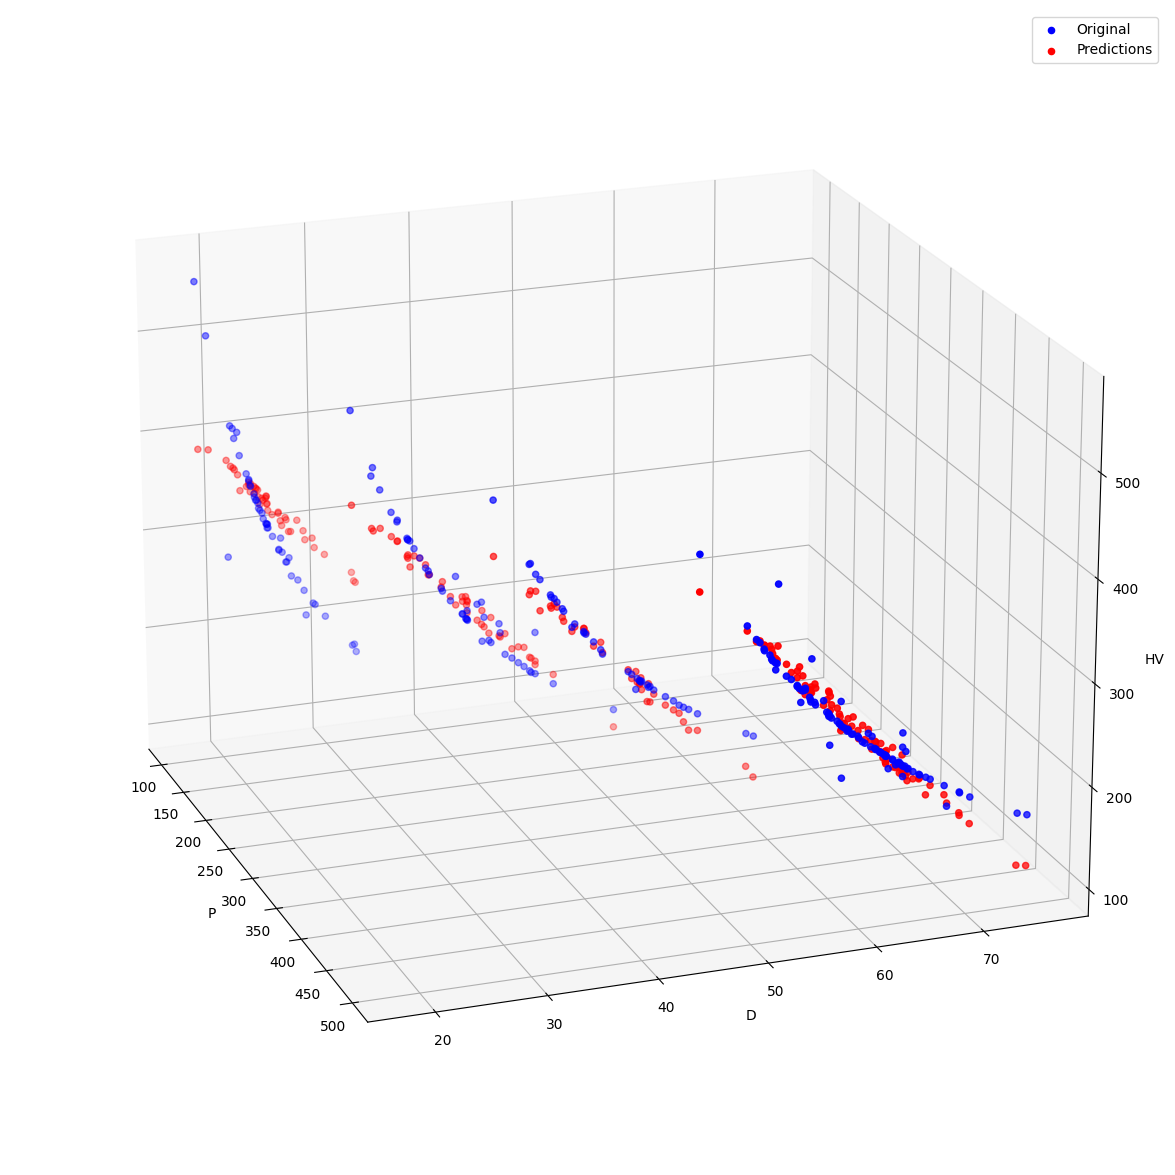

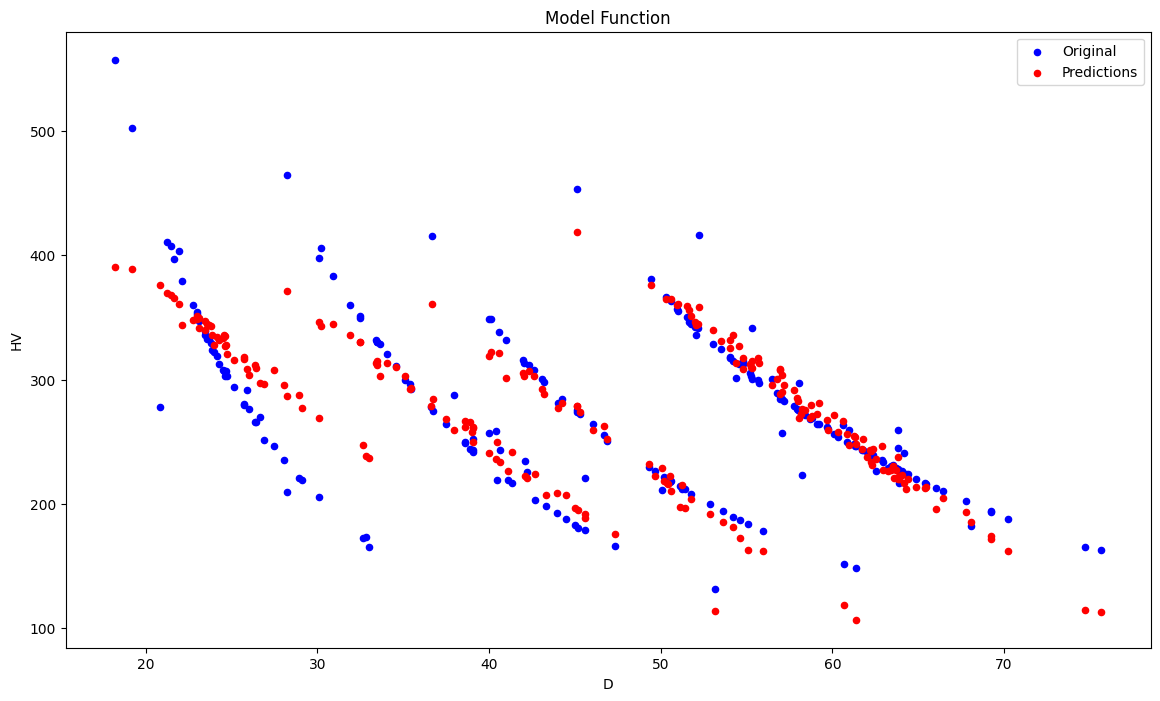

In [11]:
plot_3d_graph(bestLR, X_test, Y_test)
plot_2d_graph(bestLR, X_test, Y_test)

Модель полиномиального регрессора

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

PRModel = Pipeline([('poly', PolynomialFeatures()),
                  ('linear', LinearRegression())])

PRParameters = {'poly__degree': [2, 3, 4, 5]}

gridPR = GridSearchCV(PRModel, param_grid=PRParameters, cv=5)
gridPR.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridPR.best_params_))
bestPR = gridPR.best_estimator_
calculate_error(bestPR, X_test, Y_test)

Best hyperparameters are: {'poly__degree': 2}
R^2 score: 0.9201653943719188
MSE: 349.278
MAE: 10.557
MAPE: 0.041


Модель регрессора на случайном лесе

<ipython-input-9-cab1db7b5cc7>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-cab1db7b5cc7>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


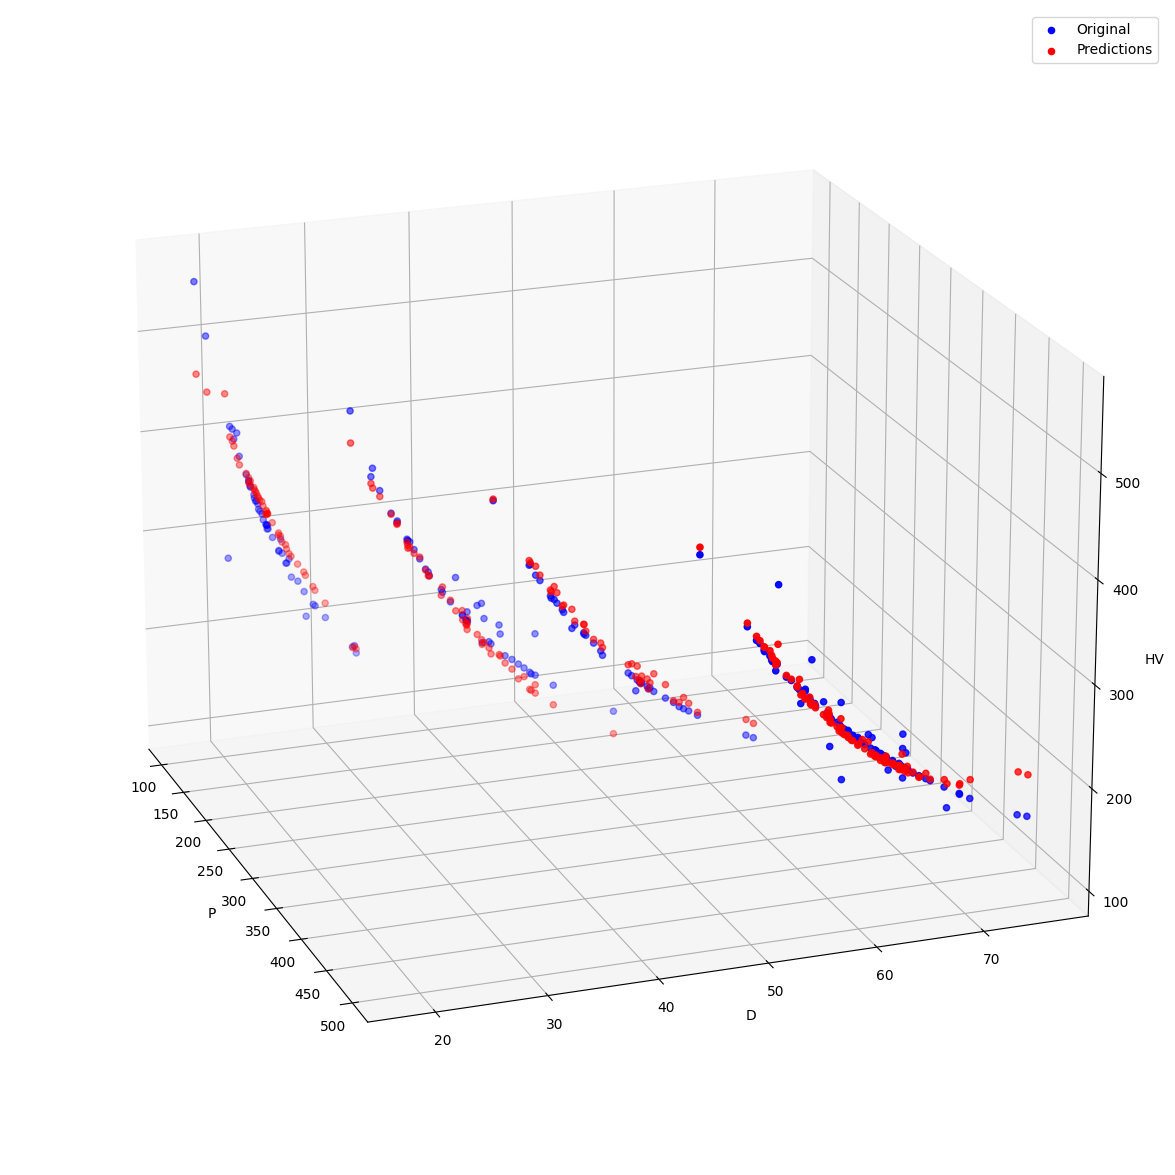

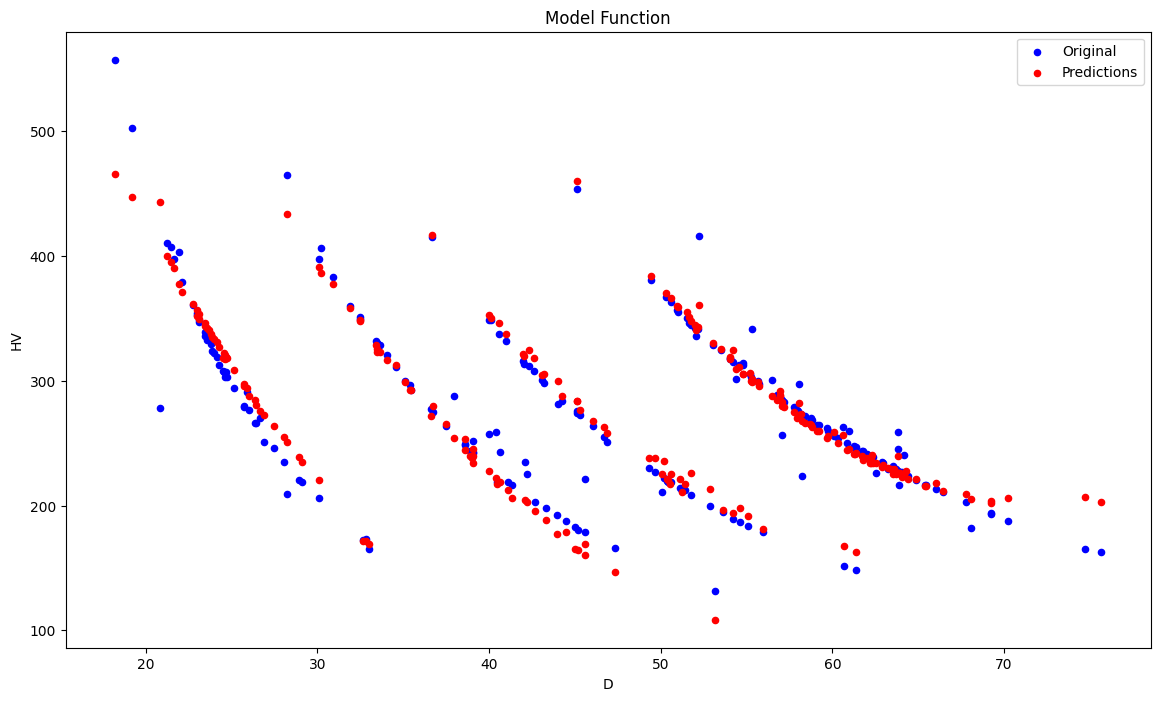

In [13]:
plot_3d_graph(bestPR, X_test, Y_test)
plot_2d_graph(bestPR, X_test, Y_test)

In [14]:
from sklearn.ensemble import RandomForestRegressor

RFModel = RandomForestRegressor()
RFParameters = {'n_estimators':[50,100,150],
                'max_depth':[3,5,10,None],
                'min_samples_split':[2,3,4],
                'min_samples_leaf':[1,2,3],
                'max_features':[1,3,5,7, "auto"]}

gridRF = GridSearchCV(estimator=RFModel, param_grid = RFParameters, n_jobs = -1, error_score='raise')
gridRF.fit(X_train, Y_train)
print('Best hyperparameters are: '+str(gridRF.best_params_))
bestRF = gridRF.best_estimator_
calculate_error(bestRF, X_test, Y_test)

Best hyperparameters are: {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
R^2 score: 0.900991235954161
MSE: 433.165
MAE: 11.241
MAPE: 0.041


<ipython-input-9-cab1db7b5cc7>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-cab1db7b5cc7>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


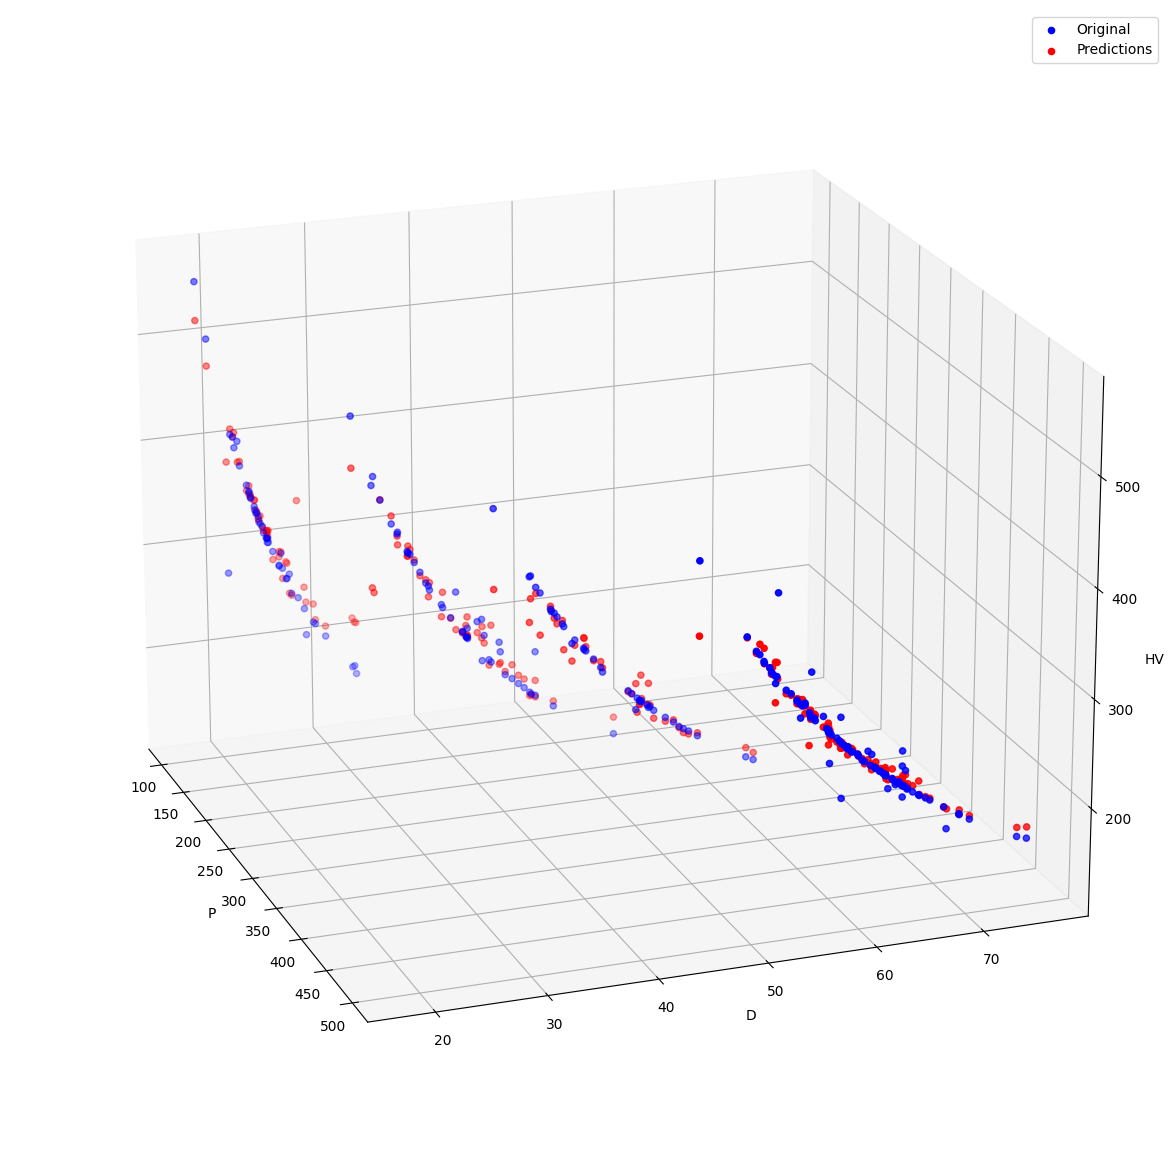

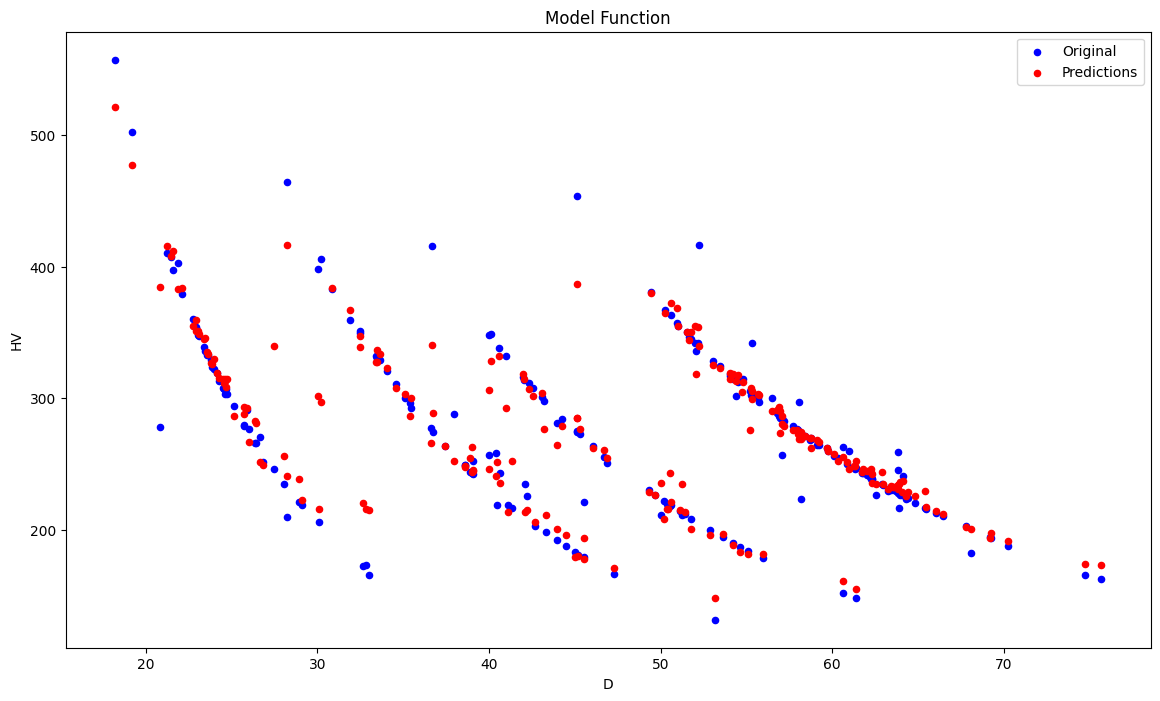

In [15]:
plot_3d_graph(bestRF, X_test, Y_test)
plot_2d_graph(bestRF, X_test, Y_test)

Модель AdaBoost Regressor




In [16]:
from sklearn.ensemble import AdaBoostRegressor

baseModel = RandomForestRegressor(max_depth = None, max_features = 3, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 150)

# Создаем модель AdaBoostRegressor на основе базовой модели
boostedModel = AdaBoostRegressor(estimator=baseModel, n_estimators=100, learning_rate=0.1)

# Обучаем модель на тренировочных данных
boostedModel.fit(X_train, Y_train)
calculate_error(boostedModel, X_test, Y_test)

R^2 score: 0.9168610132311742
MSE: 363.734
MAE: 10.264
MAPE: 0.037


Сохранение лучшей модели

<Axes: >

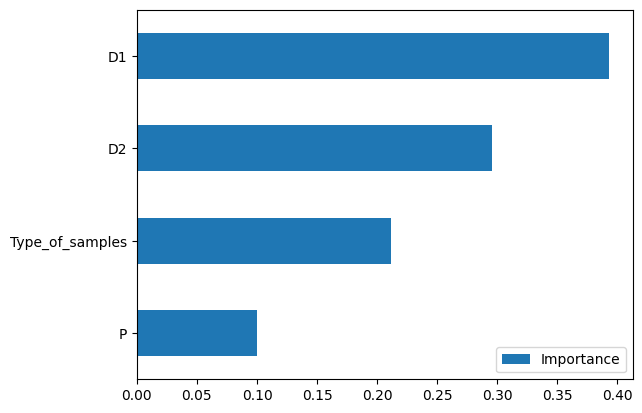

In [17]:
tree_feature_importances=pd.DataFrame(bestRF.feature_importances_,
                                      index=columns,
                                      columns=['Importance']).sort_values('Importance',
                                                                          ascending=True)
tree_feature_importances.plot.barh()

<ipython-input-9-cab1db7b5cc7>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-cab1db7b5cc7>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


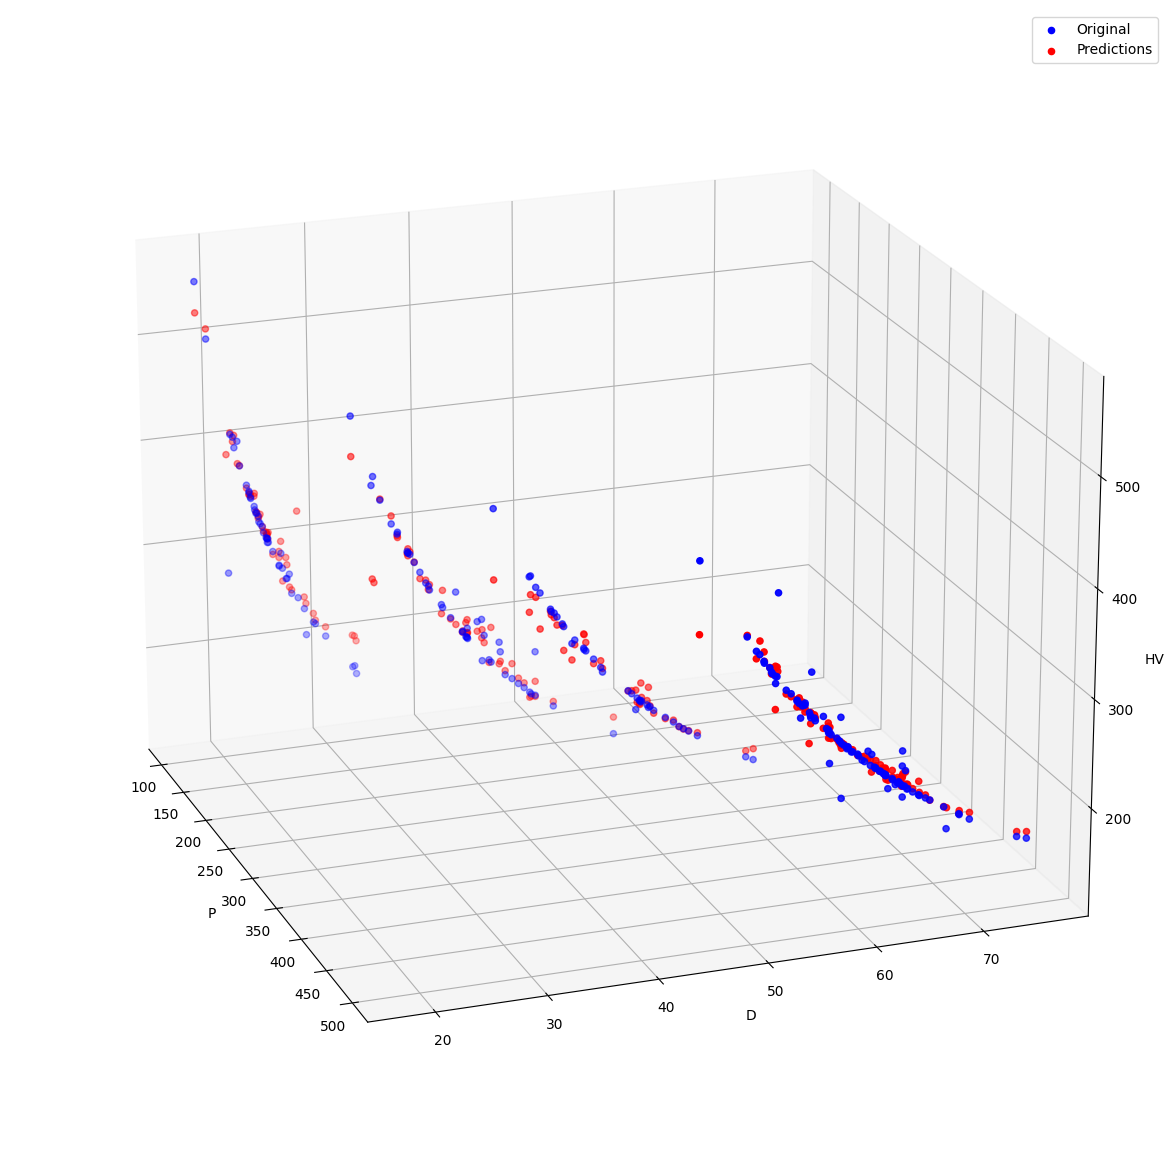

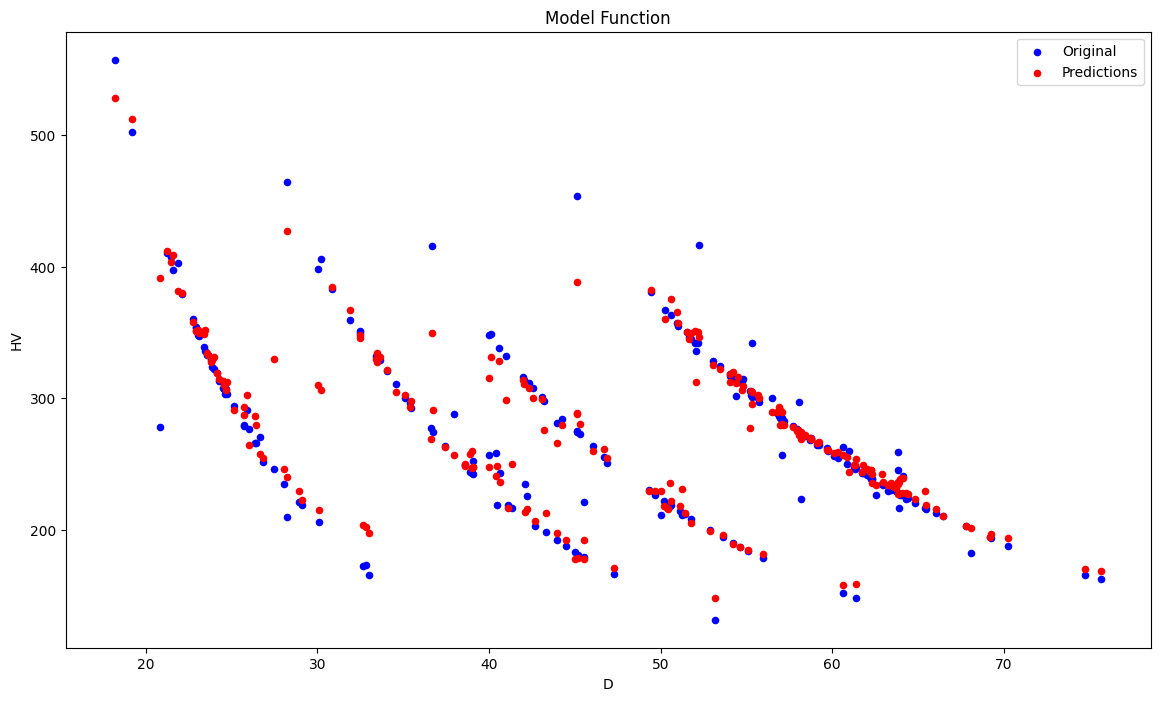

In [18]:
plot_3d_graph(boostedModel, X_test, Y_test)
plot_2d_graph(boostedModel, X_test, Y_test)

In [19]:
X = df.drop(['HV'],axis=1)
y = df['HV']

In [20]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [21]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size = 0.2,
                                                            random_state = 0)
print(f'Train : {X_train_val.shape}, Test : {X_test.shape}')

Train : (600, 4), Test : (150, 4)


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size = 0.2, random_state = 0)
print(f'Train : {X_train.shape}, Test : {X_val.shape}')

Train : (480, 4), Test : (120, 4)


In [23]:
from keras.models import Sequential
from keras.layers import Dense
regressor = Sequential()
regressor.add(Dense(32,activation='relu',input_dim=X_train.shape[1]))
regressor.add(Dense(1))

In [24]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [25]:
regressor.compile(loss='mse',optimizer='adam',metrics='mae')

In [26]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stop = EarlyStopping(monitor='val_mse',patience=10,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Temp/hardness_processing-{epoch:02d}-{val_loss:.3f}.hdf5',
                              monitor='val_loss',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

In [ ]:
regressor_history = regressor.fit(X_train, y_train, batch_size=40,
                      validation_data=(X_val,y_val), callbacks=callbacks_list, epochs=1600)

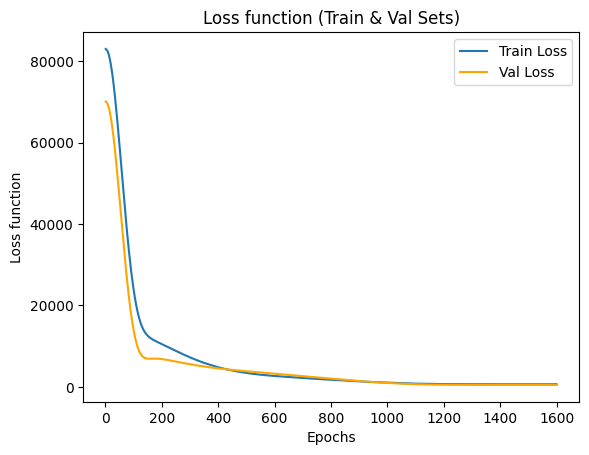

In [28]:

loss_function = regressor_history.history['loss']
val_loss_function = regressor_history.history['val_loss']
epochs = range(1,len(loss_function)+1)

plt.title('Loss function (Train & Val Sets)')
plt.plot(epochs,loss_function,label='Train Loss')
plt.plot(epochs,val_loss_function,color='orange',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()
plt.show()

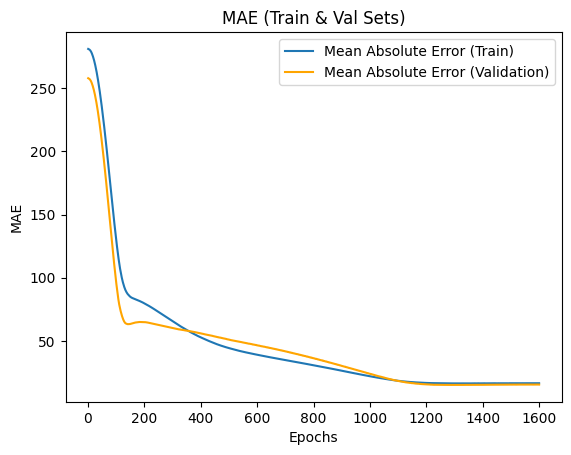

In [29]:
mae = regressor_history.history['mae']
val_mae = regressor_history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('MAE (Train & Val Sets)')
plt.plot(epochs,mae,label='Mean Absolute Error (Train)')
plt.plot(epochs,val_mae,color='orange',label='Mean Absolute Error (Validation)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [30]:
results = regressor.evaluate(X_test,y_test)

5/5 [==============================] - 0s 2ms/step - loss: 654.6293 - mae: 17.4713


In [31]:
mse = results[0]  # Индекс 0 соответствует MSE
mae = results[1]  # Индекс 1 соответствует MAE

print('MSE:', mse)
print('MAE:', mae)

MSE: 654.6292724609375
MAE: 17.471303939819336


5/5 [==============================] - 0s 1ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<ipython-input-32-2ff8455b897e>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, z1, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-32-2ff8455b897e>:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, z2, c='r', cmap='coolwarm', label='Predictions', s=20)


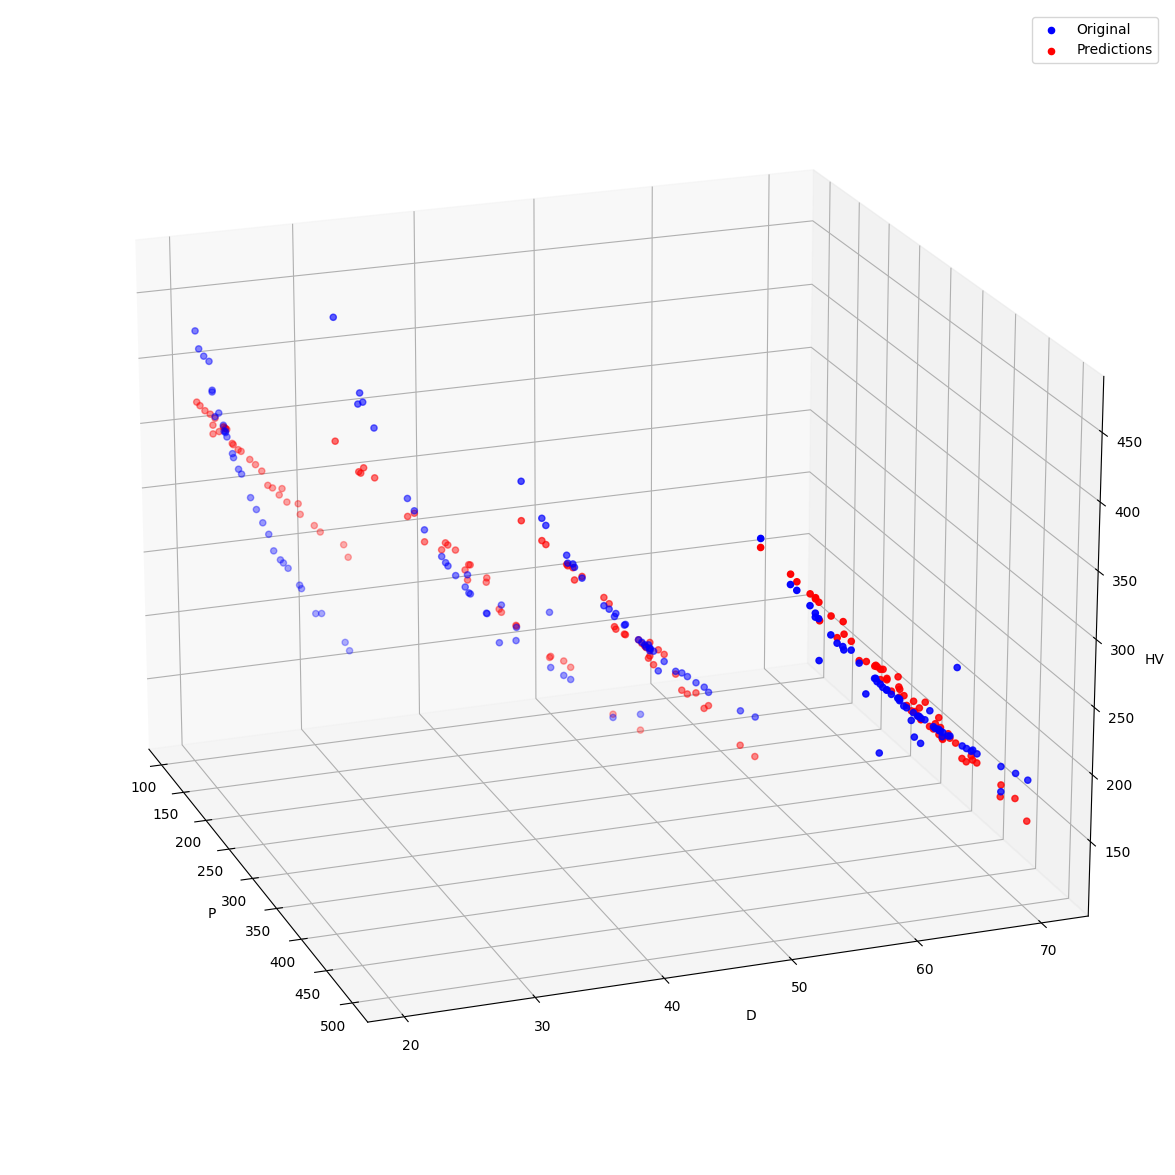

In [32]:
import matplotlib.pyplot as plt

predictions = regressor.predict(X_test)
original = y_test.to_numpy()
print(type(predictions))
print(type(original))

z1 = original
z2 = predictions
x = min_max_scaler.inverse_transform(X_test)[:, 1]
y = (min_max_scaler.inverse_transform(X_test)[:, 2] + min_max_scaler.inverse_transform(X_test)[:, 3]) / 2

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=340, elev=20)
sc1 = ax.scatter(x, y, z1, c='b', cmap='coolwarm', label='Original', s=20)
sc2 = ax.scatter(x, y, z2, c='r', cmap='coolwarm', label='Predictions', s=20)
ax.set_xlabel('P')
ax.set_ylabel('D')
ax.set_zlabel('HV')
ax.legend(handles=[sc1, sc2], loc='best')
plt.show()

5/5 [==============================] - 0s 1ms/step


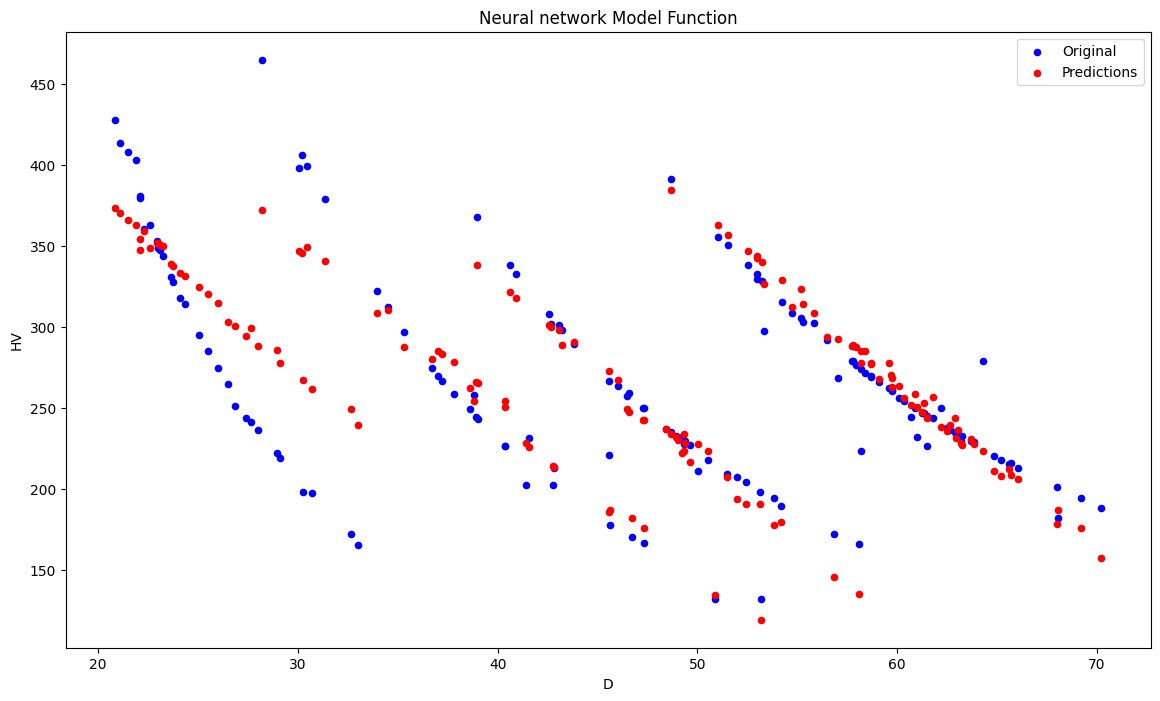

In [33]:
import matplotlib.pyplot as plt

predictions = regressor.predict(X_test)
original = y_test.to_numpy()

z1 = original
z2 = predictions
x = (min_max_scaler.inverse_transform(X_test)[:, 2] + min_max_scaler.inverse_transform(X_test)[:, 3]) / 2

fig = plt.figure(figsize=(14, 8))
plt.scatter(x, z1, c='b', label='Original', s=20)
plt.scatter(x, z2, c='r', label='Predictions', s=20)
plt.xlabel('D')
plt.ylabel('HV')
plt.title('Neural network Model Function')
plt.legend()
plt.show()

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(dfX, dfY, test_size=0.3,
                                                    random_state=1)

In [35]:
from sklearn.linear_model import LassoCV
LassoRegressor = LassoCV()
LassoRegressor.fit(X_train, Y_train)
calculate_error(LassoRegressor, X_test, Y_test)

R^2 score: 0.8142433859839092
MSE: 812.688
MAE: 18.353
MAPE: 0.069


<ipython-input-9-cab1db7b5cc7>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-cab1db7b5cc7>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


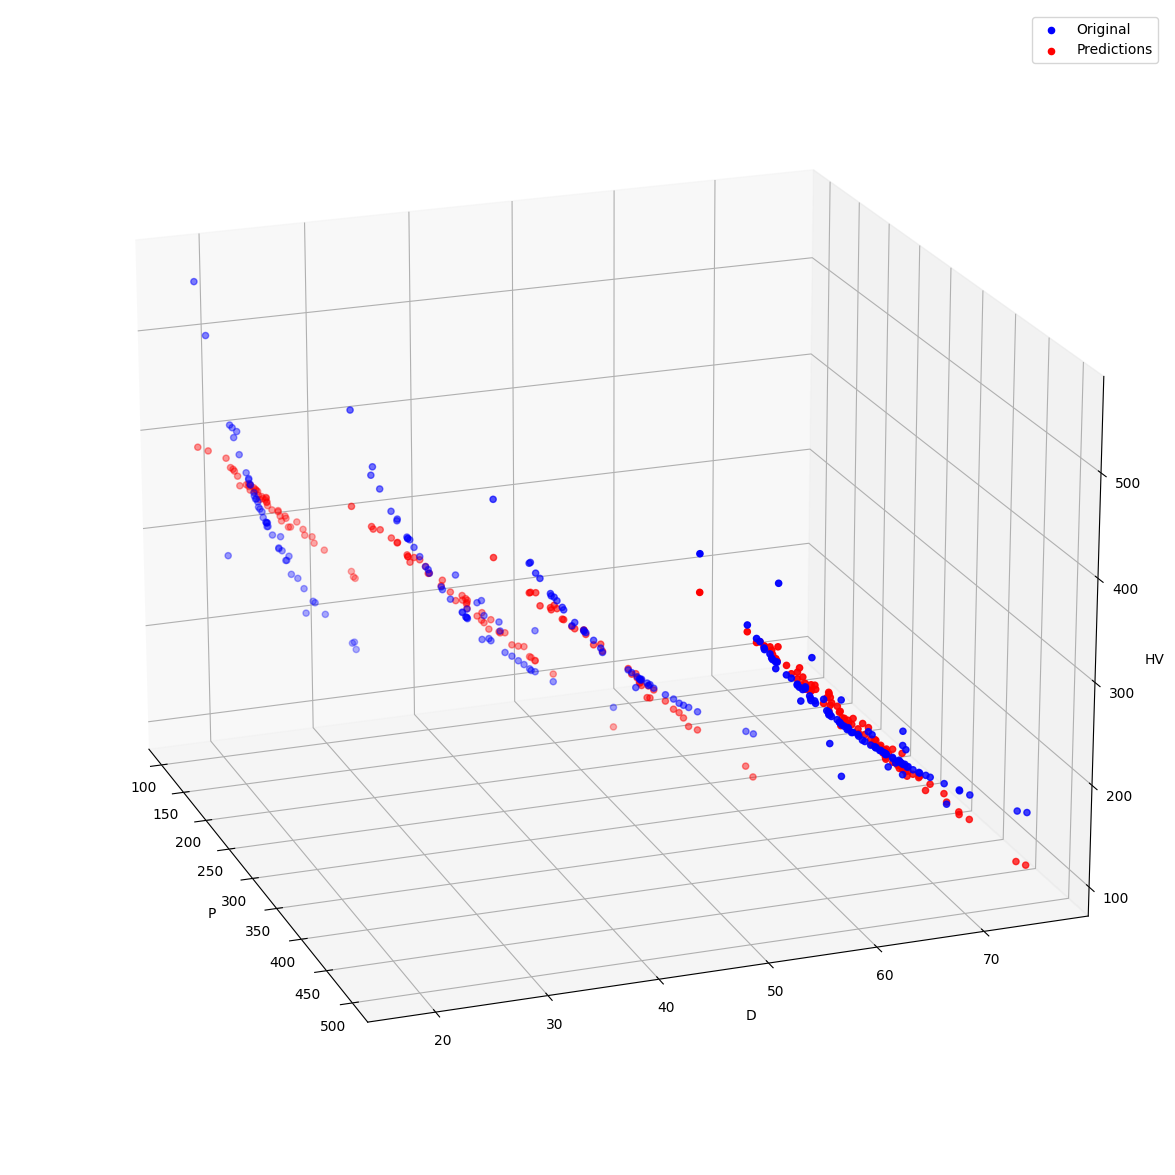

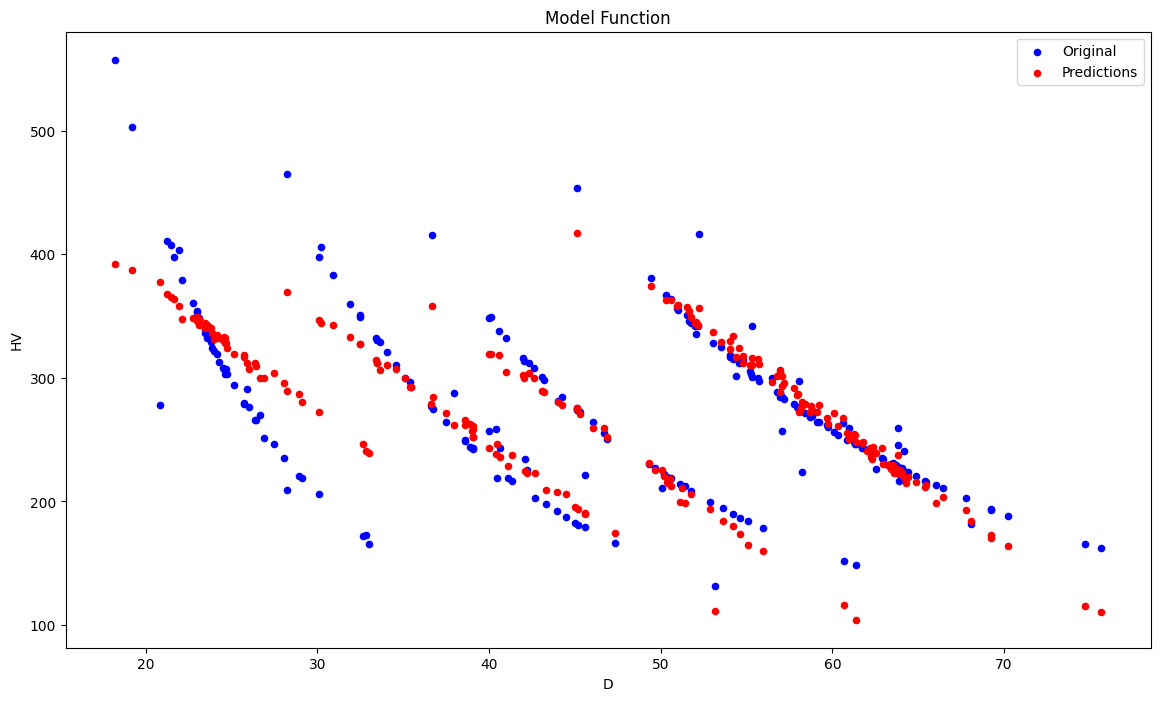

In [36]:
plot_3d_graph(LassoRegressor, X_test, Y_test)
plot_2d_graph(LassoRegressor, X_test, Y_test)

In [37]:
from sklearn.linear_model import RidgeCV
RidgeRegressor = RidgeCV()
RidgeRegressor.fit(X_train, Y_train)
calculate_error(RidgeRegressor, X_test, Y_test)

R^2 score: 0.8163142246511551
MSE: 803.628
MAE: 18.568
MAPE: 0.07


<ipython-input-9-cab1db7b5cc7>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-cab1db7b5cc7>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


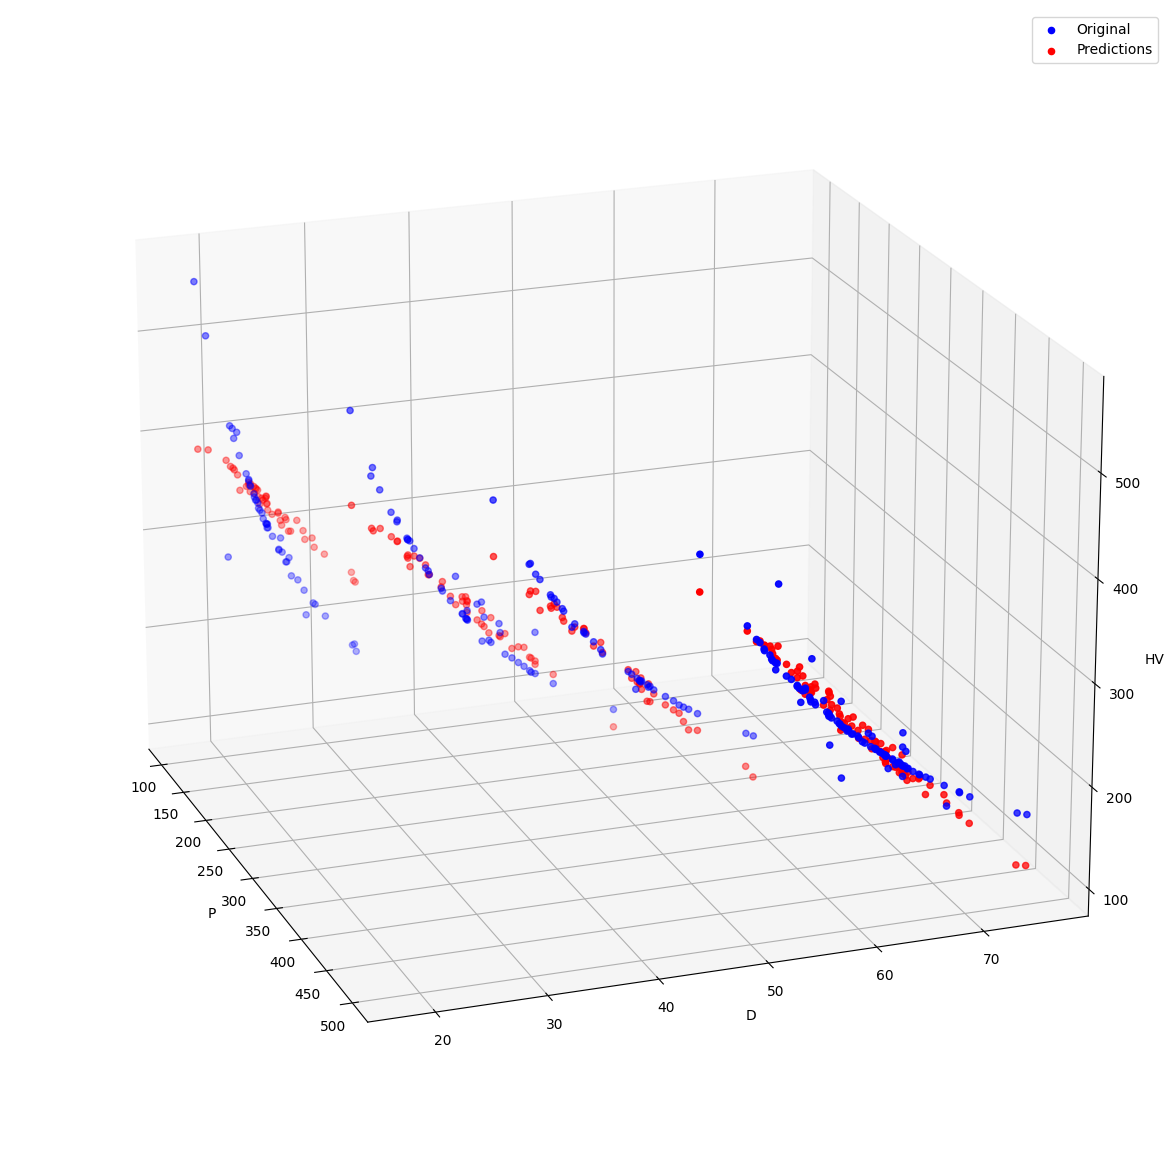

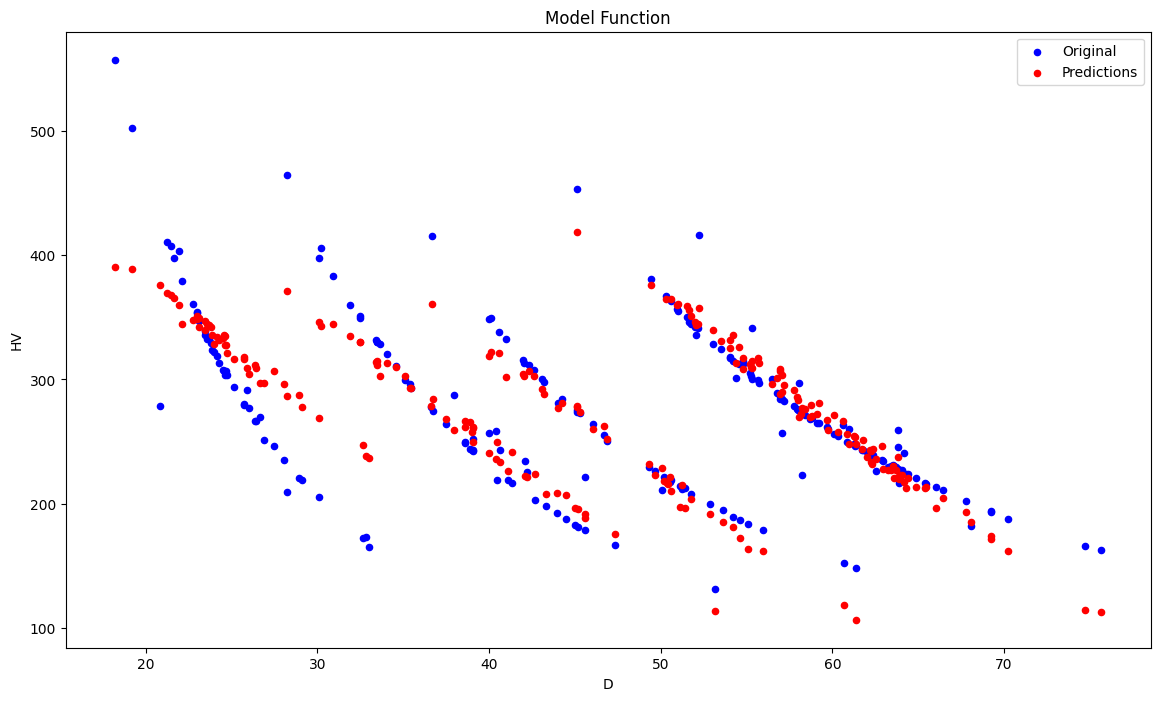

In [38]:
plot_3d_graph(RidgeRegressor, X_test, Y_test)
plot_2d_graph(RidgeRegressor, X_test, Y_test)

In [39]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

# Определение модели
ElasticNetRegressor = ElasticNetCV()

# Определение сетки параметров для перебора
param_grid = {
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    'eps': [1e-3, 1e-4, 1e-5],
    'n_alphas': [50, 100, 200],
    'max_iter': [1000, 2000, 5000],
    'tol': [1e-3, 1e-4, 1e-5],
    'cv': [3, 5, 10],
    'positive': [False, True]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(ElasticNetRegressor, param_grid)

# Поиск лучших гиперпараметров
grid_search.fit(X_train, Y_train)

# Вывод наилучших параметров
print("Best Parameters: ", grid_search.best_params_)
bestElasticNet = grid_search.best_estimator_


# Предсказание на тестовых данных с использованием наилучших параметров
calculate_error(bestElasticNet, X_test, Y_test)

Best Parameters:  {'cv': 5, 'eps': 1e-05, 'l1_ratio': 1.0, 'max_iter': 1000, 'n_alphas': 50, 'positive': False, 'tol': 0.001}
R^2 score: 0.8163349537134063
MSE: 803.538
MAE: 18.588
MAPE: 0.07


<ipython-input-9-cab1db7b5cc7>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax.scatter(x, y, original, c='b', cmap='coolwarm', label='Original', s=20)
<ipython-input-9-cab1db7b5cc7>:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc2 = ax.scatter(x, y, predictions, c='r', cmap='coolwarm', label='Predictions', s=20)


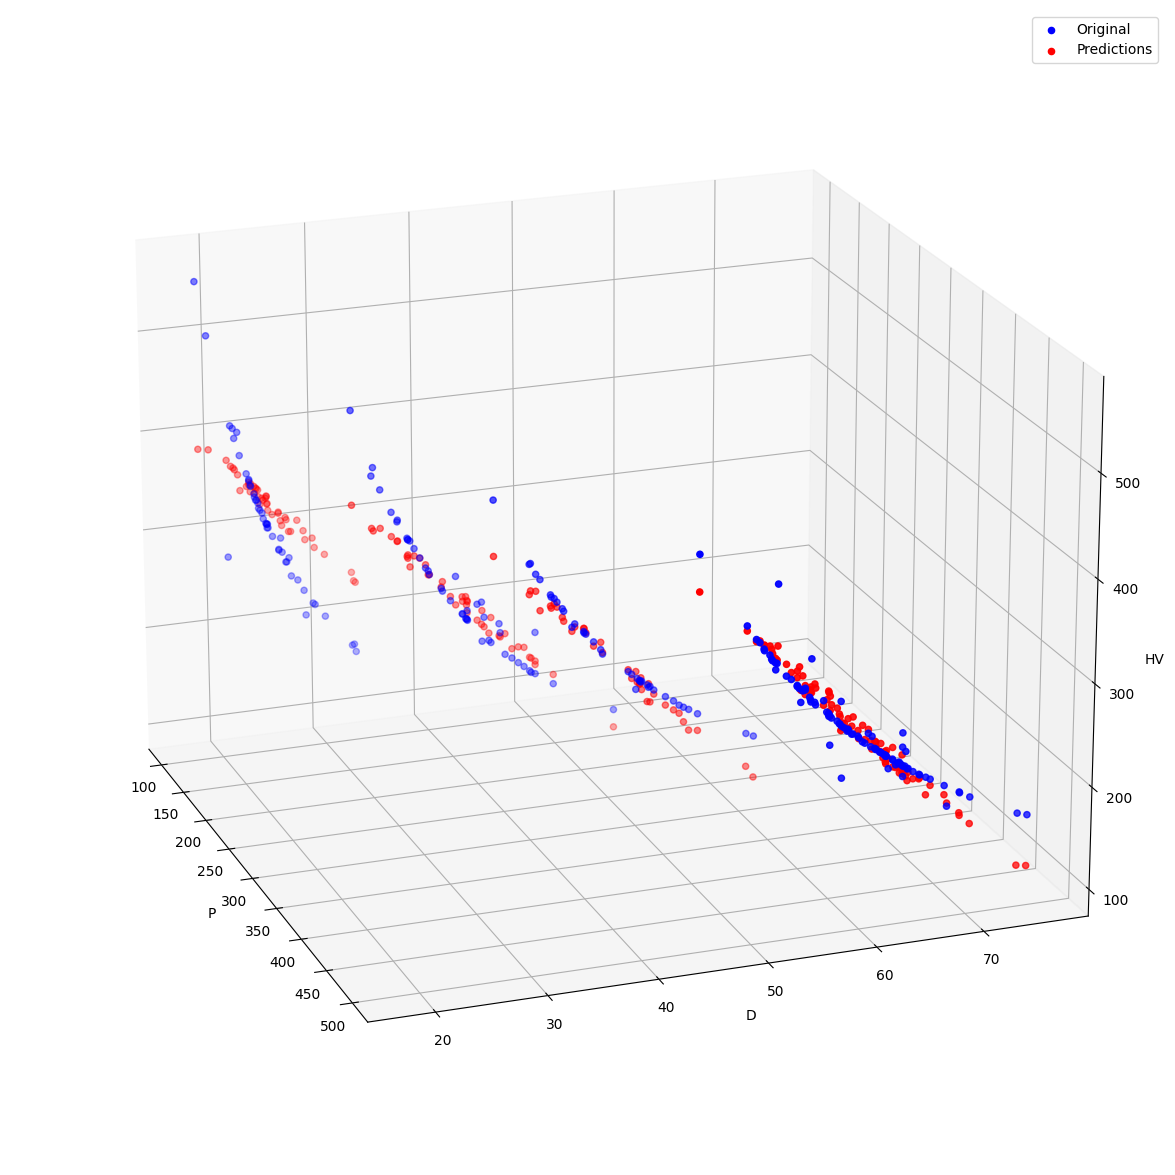

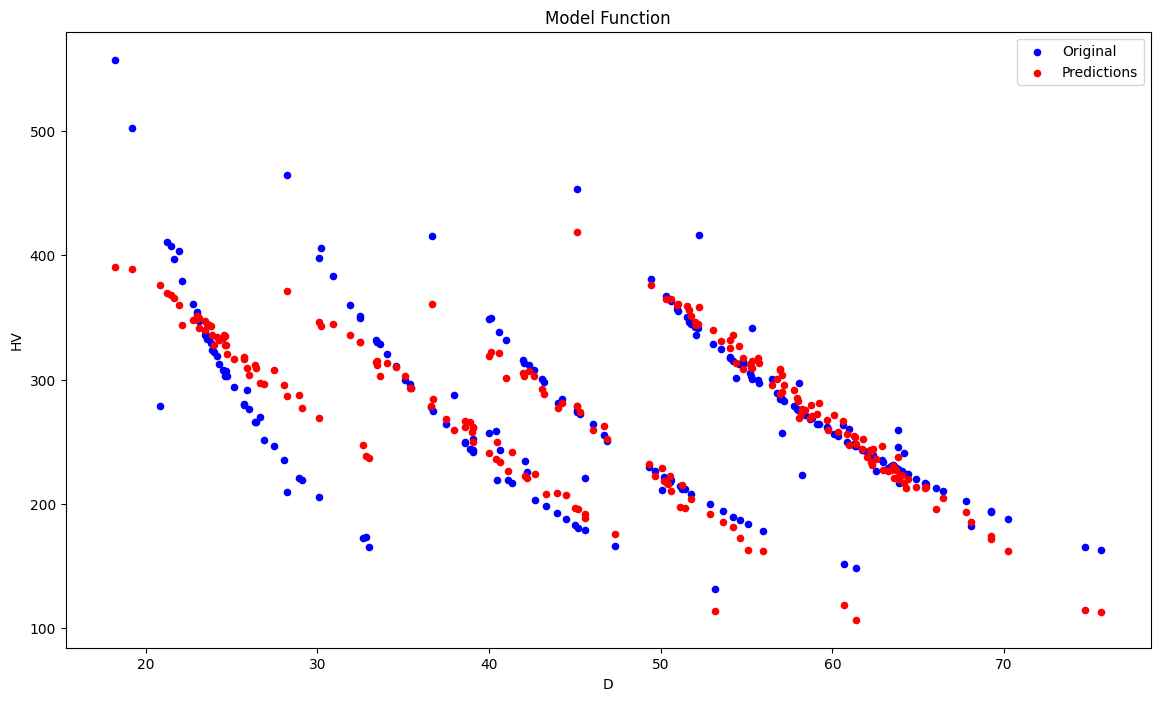

In [40]:
plot_3d_graph(bestElasticNet, X_test, Y_test)
plot_2d_graph(bestElasticNet, X_test, Y_test)